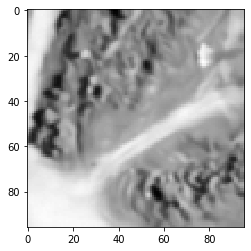

/home/anshul/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/anshul/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


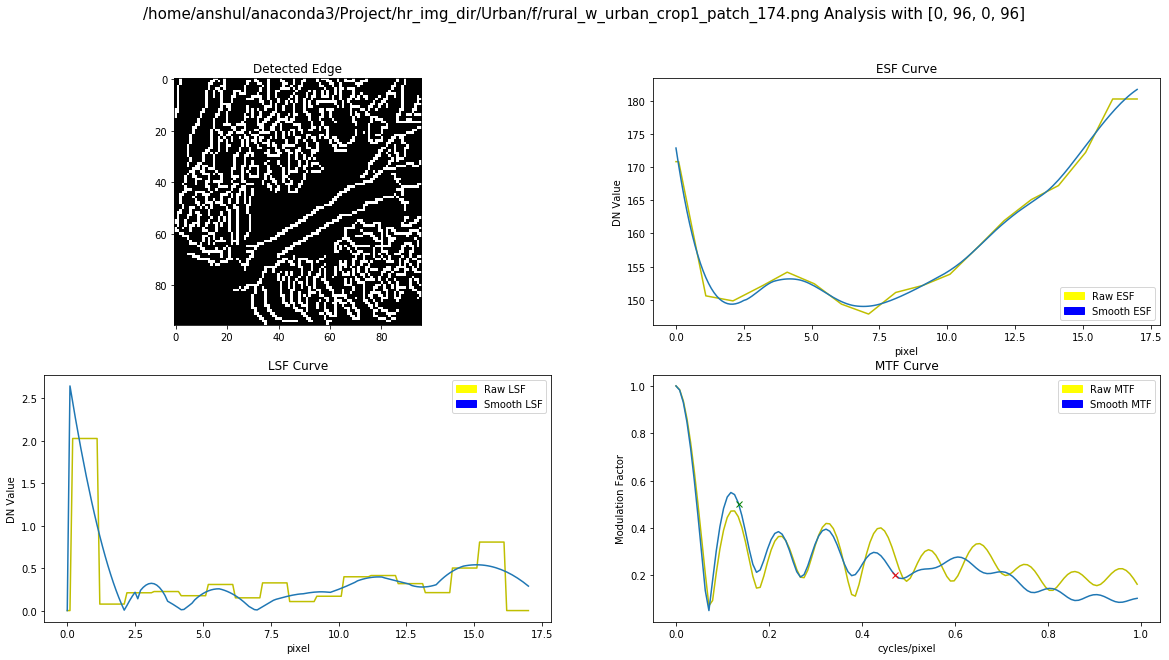

mtf50 is 0.13, mtf20 is 0.47


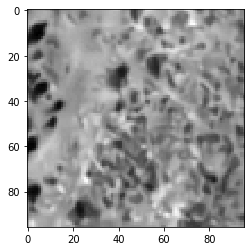

/home/anshul/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/anshul/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


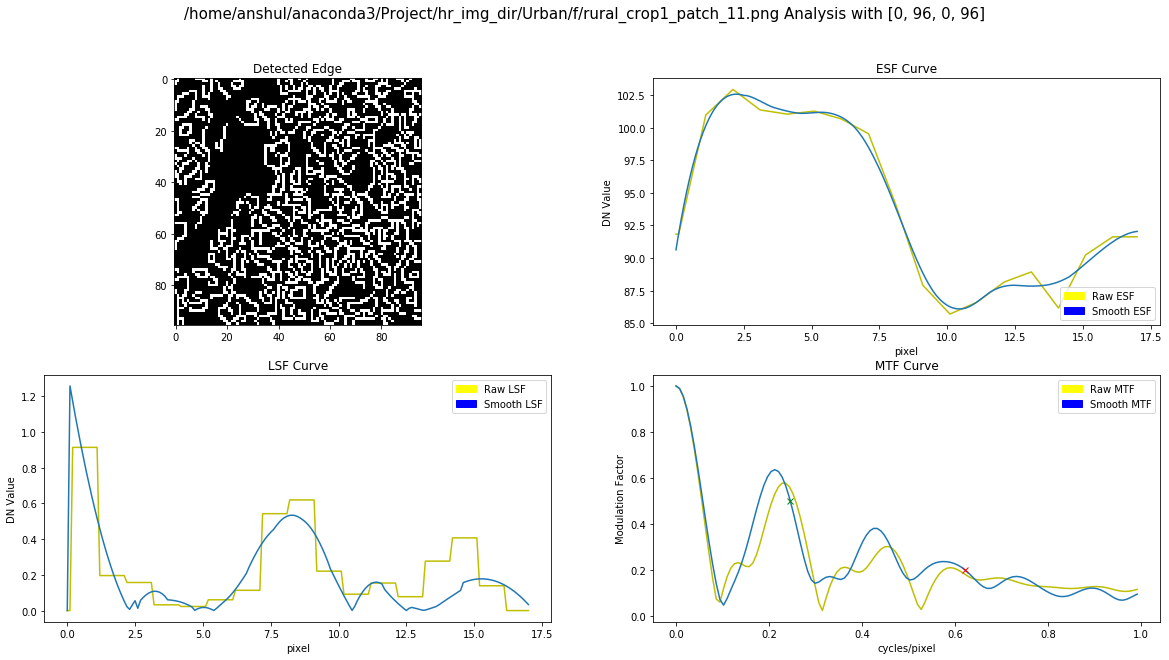

mtf50 is 0.25, mtf20 is 0.62


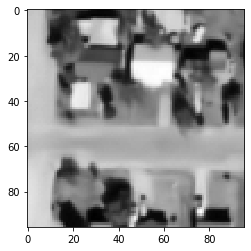

/home/anshul/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/anshul/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


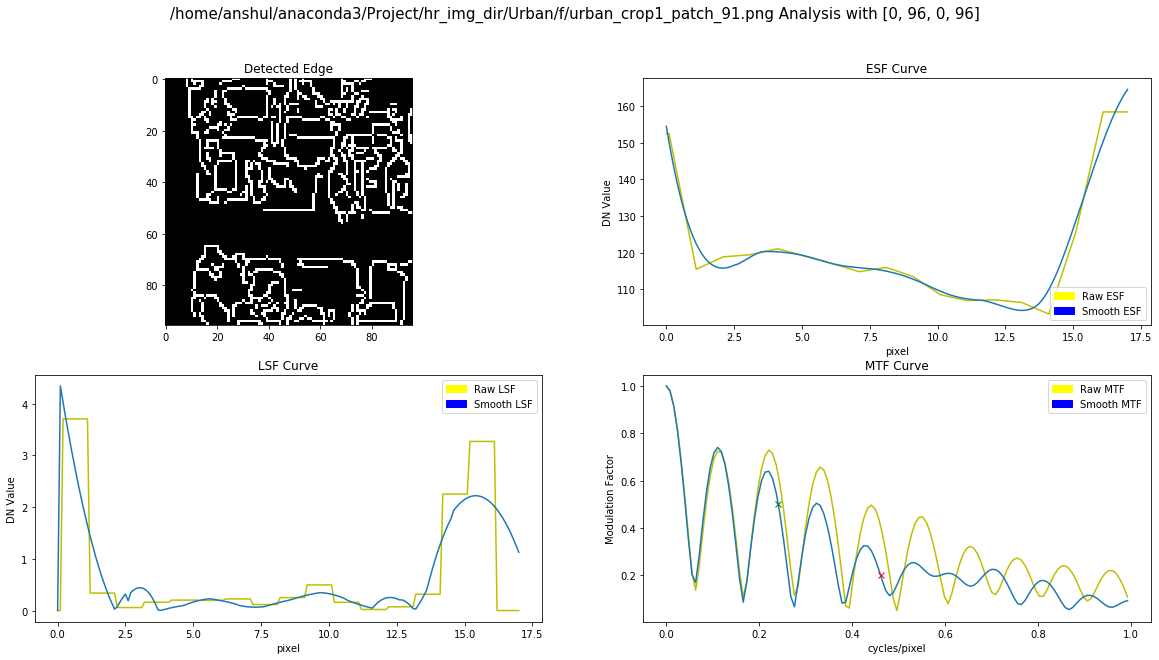

mtf50 is 0.24, mtf20 is 0.46


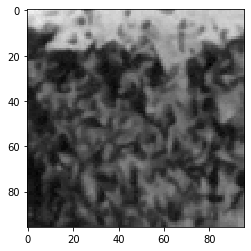

/home/anshul/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/anshul/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


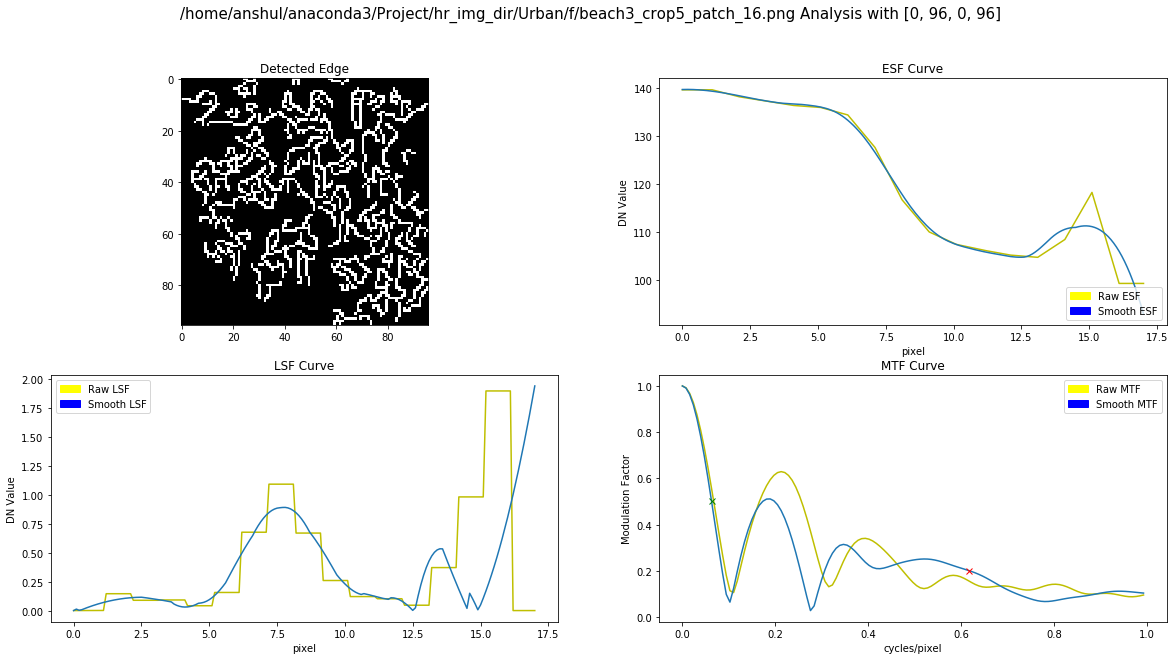

mtf50 is 0.06, mtf20 is 0.62


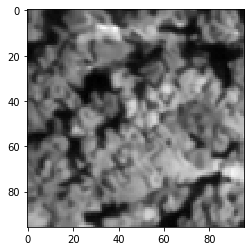

/home/anshul/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/anshul/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


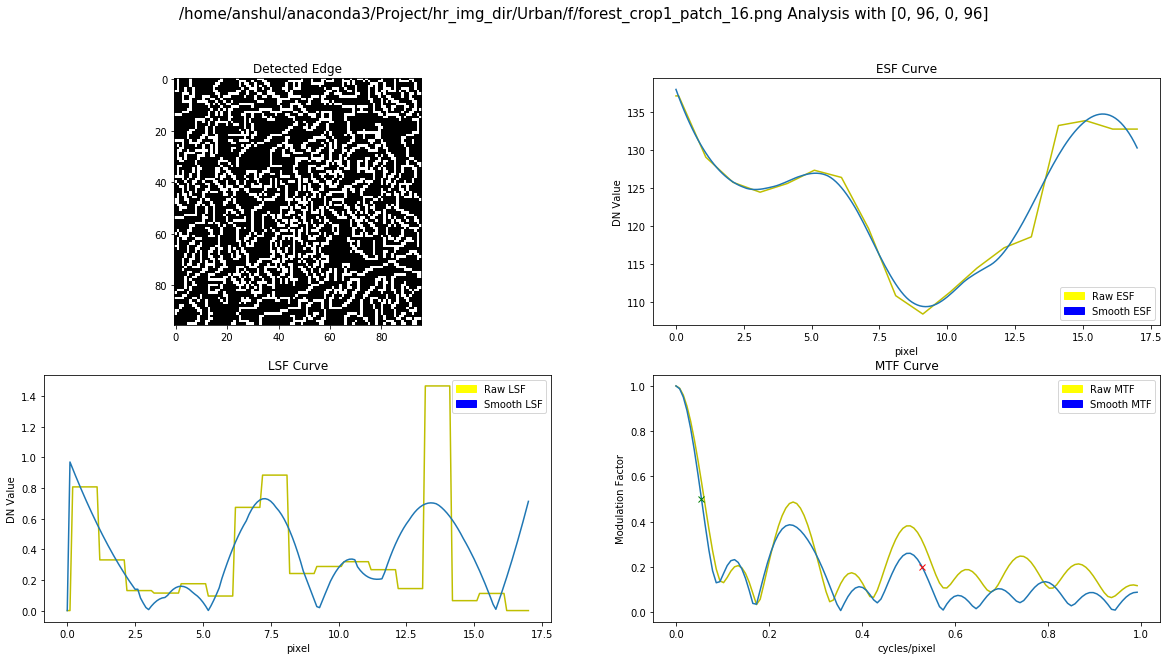

mtf50 is 0.05, mtf20 is 0.53


In [8]:
import numpy as np
import cv2
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.widgets import RectangleSelector
from scipy import interpolate
from scipy.signal import savgol_filter
import os
from PIL import Image
import glob


# Reference:
# http://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.
    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        # >>> # linear interpolation of NaNs
        # >>> nans, x= nan_helper(y)
        # >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]


class EventHandler(object):

    def __init__(self, filename):
        self.filename = filename

    def line_select_callback(self, eclick, erelease):
        'eclick and erelease are the press and release events'
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        self.roi = np.array([y1, y2, x1, x2])

    def event_exit_manager(self, event):
        if event.key in ['enter']:
            PDS_Compute_MTF(self.filename, self.roi)


class ROI_selection(object):

    def __init__(self, filename):
        self.filename = filename
        self.image_data = cv2.imread(filename, 0)
        fig_image, current_ax = plt.subplots()
        plt.imshow(self.image_data, cmap='gray')
        eh = EventHandler(self.filename)
        rectangle_selector = RectangleSelector(current_ax,
                                               eh.line_select_callback,
                                               drawtype='box',
                                               useblit=True,
                                               button=[1, 2, 3],
                                               minspanx=5, minspany=5,
                                               spancoords='pixels',
                                               interactive=True)
        plt.connect('key_press_event', eh.event_exit_manager)
        plt.show()


class PDS_Compute_MTF(object):

    def __init__(self, filename, roi):
        image_data = cv2.imread(filename, 0)
        image_data = image_data[roi[0]:roi[1], roi[2]:roi[3]]
        self.data = image_data
        _, th = cv2.threshold(self.data, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if (image_data.size == 256, 256):
            self.min = 30
            self.max = 100
        else:
            self.min = np.amin(self.data)
            self.max = np.amax(self.data)
        self.threshold = th*(self.max - self.min) + self.min
        below_thresh = ((self.data >= self.min) & (self.data <= self.threshold))
        above_thresh = ((self.data >= self.threshold) & (self.data <= self.max))
        area_below_thresh = self.data[below_thresh].sum()/below_thresh.sum()
        area_above_thresh = self.data[above_thresh].sum()/above_thresh.sum()
        self.threshold = (area_below_thresh - area_above_thresh)/2 + area_above_thresh

        edges = cv2.Canny(self.data, self.min, self.max-5)
        fig = plt.figure(figsize=(20,10))
        fig.suptitle(filename + ' Analysis with ' + str(roi), fontsize=15)
        plt.subplot(2, 2, 1)
        plt.imshow(edges, cmap='gray')
        plt.title("Detected Edge")
        row_edge, col_edge = np.where(edges == 255)
        z = np.polyfit(np.flipud(col_edge), row_edge, 1)
        angle_radians = np.arctan(z[0])
        angle_deg = angle_radians * (180/3.14)
        # print(angle_deg)
        if abs(angle_deg) < 45:
            self.data = np.transpose(self.data)
        self.compute_esf()

    def compute_esf(self):
        kernel = np.ones((3, 3), np.float32)/9
        smooth_img = cv2.filter2D(self.data, -1, kernel)
        row = self.data.shape[0]
        column = self.data.shape[1]
        array_values_near_edge = np.empty([row, 13])
        array_positions = np.empty([row, 13])
        edge_pos = np.empty(row)
        smooth_img = smooth_img.astype(float)
        for i in range(0, row):
            # print(smooth_img[i,:])
            diff_img = smooth_img[i, 1:] - smooth_img[i, 0:(column-1)]
            abs_diff_img = np.absolute(diff_img)
            abs_diff_max = np.amax(abs_diff_img)
            if abs_diff_max == 1:
                raise IOError('No Edge Found')
            app_edge = np.where(abs_diff_img == abs_diff_max)
            bound_edge_left = app_edge[0][0] - 2
            bound_edge_right = app_edge[0][0] + 3
            if bound_edge_right > column or bound_edge_left < 0:
                if bound_edge_right > column:
                    # padding image edge using mirror copy
                    margin = bound_edge_right - column
                    strip_cropped[:-margin] = self.data[i, bound_edge_left:bound_edge_right]
                    for j in range(margin):
                        strip_cropped[-margin + j] = self.data[i, -(2 + j)]
                if bound_edge_left < 0:
                    # padding image edge using mirror copy
                    margin = -bound_edge_left
                    strip_cropped[margin:] = self.data[i, :bound_edge_right]
                    for j in range(margin):
                        strip_cropped[margin-1-j] = self.data[i, j+1]
            else:
                strip_cropped = self.data[i, bound_edge_left:bound_edge_right]

            temp_y = np.arange(1, 6)
            f = interpolate.interp1d(strip_cropped, temp_y, kind='nearest', fill_value='extrapolate')
            edge_pos_temp = f(self.threshold)
            edge_pos[i] = edge_pos_temp + bound_edge_left - 1
            bound_edge_left_expand = app_edge[0][0] - 6
            bound_edge_right_expand = app_edge[0][0] + 7
            if bound_edge_right_expand > column or bound_edge_left_expand < 0:
                if bound_edge_right_expand > column:
                    # padding image edge using mirror copy
                    margin = bound_edge_right_expand - column
                    array_values_near_edge[i, :-margin] = self.data[i, bound_edge_left_expand:bound_edge_right_expand]
                    for j in range(margin):
                        array_values_near_edge[i, -margin+j] = self.data[i,-(2+j)]
                if bound_edge_left_expand < 0:
                    # padding image edge using mirror copy
                    margin = -bound_edge_left_expand
                    array_values_near_edge[i, margin:] = self.data[i, :bound_edge_right_expand]
                    for j in range(margin):
                        array_values_near_edge[i, margin-1-j] = self.data[i, j+1]
            else:
                array_values_near_edge[i, :]= self.data[i, bound_edge_left_expand:bound_edge_right_expand]
            array_positions[i, :] = np.arange(bound_edge_left_expand, bound_edge_right_expand)
        y = np.arange(0, row)
        nans, x = nan_helper(edge_pos)
        edge_pos[nans] = np.interp(x(nans), x(~nans), edge_pos[~nans])

        array_positions_by_edge = array_positions - np.transpose(edge_pos * np.ones((13, 1)))
        num_row = array_positions_by_edge.shape[0]
        num_col = array_positions_by_edge.shape[1]
        array_values_by_edge = np.reshape(array_values_near_edge, num_row*num_col, order='F')
        array_positions_by_edge = np.reshape(array_positions_by_edge, num_row*num_col, order='F')

        bin_pad = 0.0001
        pixel_subdiv = 0.10
        topedge = np.amax(array_positions_by_edge) + bin_pad + pixel_subdiv
        botedge = np.amin(array_positions_by_edge) - bin_pad
        binedges = np.arange(botedge, topedge+1, pixel_subdiv)
        numbins = np.shape(binedges)[0] - 1

        binpositions = binedges[0:numbins] + (0.5) * pixel_subdiv

        h, whichbin = np.histogram(array_positions_by_edge, binedges)
        whichbin = np.digitize(array_positions_by_edge, binedges)
        binmean = np.empty(numbins)

        for i in range(0, numbins):
            flagbinmembers = (whichbin == i)
            binmembers = array_values_by_edge[flagbinmembers]
            binmean[i] = np.mean(binmembers)
        nans, x = nan_helper(binmean)
        binmean[nans] = np.interp(x(nans), x(~nans), binmean[~nans])
        esf = binmean
        xesf = binpositions
        xesf = xesf - np.amin(xesf)
        self.xesf = xesf
        esf_smooth = savgol_filter(esf, 51, 3)
        self.esf = esf
        self.esf_smooth = esf_smooth
        plt.subplot(2, 2, 2)
        plt.title("ESF Curve")
        plt.xlabel("pixel")
        plt.ylabel("DN Value")
        plt.plot(xesf, esf, 'y-', xesf, esf_smooth)
        yellow_patch = mpatches.Patch(color='yellow', label='Raw ESF')
        blue_patch = mpatches.Patch(color='blue', label='Smooth ESF')
        plt.legend(handles=[yellow_patch, blue_patch], loc=4)
        self.compute_lsf()

    def compute_lsf(self):
        diff_esf = abs(self.esf[1:] - self.esf[0:(self.esf.shape[0] - 1)])
        diff_esf = np.append(0, diff_esf)
        lsf = diff_esf
        diff_esf_smooth = abs(self.esf_smooth[0:(self.esf.shape[0] - 1)] - self.esf_smooth[1:])
        diff_esf_smooth = np.append(0, diff_esf_smooth)
        lsf_smooth = diff_esf_smooth
        self.lsf = lsf
        self.lsf_smooth = lsf_smooth
        plt.subplot(2, 2, 3)
        plt.title("LSF Curve")
        plt.xlabel("pixel")
        plt.ylabel("DN Value")
        plt.plot(self.xesf, lsf, 'y-', self.xesf, lsf_smooth)
        yellow_patch = mpatches.Patch(color='yellow', label='Raw LSF')
        blue_patch = mpatches.Patch(color='blue', label='Smooth LSF')
        plt.legend(handles=[yellow_patch, blue_patch])
        self.compute_mtf()

    def compute_mtf(self):
        mtf = np.absolute(np.fft.fft(self.lsf, 2048))
        mtf_smooth = np.absolute(np.fft.fft(self.lsf_smooth, 2048))
        mtf_final = np.fft.fftshift(mtf)
        mtf_final_smooth = np.fft.fftshift(mtf_smooth)
        plt.subplot(2, 2, 4)
        x_mtf_final = np.arange(0,1,1./127)
        mtf_final = mtf_final[1024:1151]/np.amax(mtf_final[1024:1151])
        mtf_final_smooth = mtf_final_smooth[1024:1151]/np.amax(mtf_final_smooth[1024:1151])
        # compute MTF50 & MTF20 from filtered MTF
        mtf50 = np.interp(0.5, mtf_final_smooth[::-1], x_mtf_final[::-1])
        mtf20 = np.interp(0.2, mtf_final_smooth[::-1], x_mtf_final[::-1])
        plt.plot(x_mtf_final, mtf_final, 'y-', x_mtf_final, mtf_final_smooth)
        plt.plot(mtf50, 0.5, 'gx')
        plt.plot(mtf20, 0.2, 'rx')

        plt.xlabel("cycles/pixel")
        plt.ylabel("Modulation Factor")
        plt.title("MTF Curve")
        yellow_patch = mpatches.Patch(color='yellow', label='Raw MTF')
        blue_patch = mpatches.Patch(color='blue', label='Smooth MTF')
        plt.legend(handles=[yellow_patch, blue_patch])
        outfile='mtf_curve'+str(n)+'.png'
        plt.savefig(os.path.join(newpath,outfile))
        plt.show()
        print('mtf50 is %.2f, mtf20 is %.2f'%(mtf50, mtf20))

img_dir = r'/home/anshul/anaconda3/Project/hr_img_dir/Urban/f'# Enter Directory of all images 
newpath=r'/home/anshul/anaconda3/Project/hr_img_dir/Urban/na1'
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
data=[]

n=1                    
for f1 in files:
    roi = ROI_selection(f1)
    area = [0, roi.image_data.shape[0], 0, roi.image_data.shape[1]]
    mtf = PDS_Compute_MTF(f1, area)
    n+=1